# Imports

In [53]:
import torch
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms_v2

from torch import optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [54]:
import os
import cv2
import math
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Data Loading

In [55]:
# Charger le fichier Pickle
train_data_path = Path('data/train_data.pkl')
with open(train_data_path, 'rb') as f:
    data = pickle.load(f)

images = data['images']
labels = data['labels']

In [56]:
images.shape, labels.shape

((1080, 28, 28, 3), (1080, 1))

In [57]:
image_ex = images[0]
label_ex = labels[0]
image_ex.shape, label_ex.shape

((28, 28, 3), (1,))

Notre CNN nécessitera le nombre de canaux de nos images (grayscale ou RGB) et la taille de notre image :

In [58]:
nb_of_channels = image_ex.shape[2]
dimension_of_image = image_ex.shape[0]
nb_of_channels, dimension_of_image

(3, 28)

Pour connaître le nombre de classes que l'on peut prédire, on fait :

In [59]:
nb_of_classes = len(np.unique(labels.flatten()))
nb_of_classes

5

# Architecture Design & HPs

In [60]:
if torch.cuda.is_available(): device = 'cuda'
elif torch.mps.is_available(): device = 'mps' 
else: device = 'cpu'

In [61]:
class CNN(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, dimension_of_image: int):
        """
        This CNN architecture was inspired from the following paper:
            - https://www.nature.com/articles/s41598-025-87171-9
        """
        super(CNN, self).__init__()

        pool_kernel_size = 2
        nb_of_pooling_step = 2

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)
        )

        dim_after_convs = dimension_of_image // (nb_of_pooling_step * pool_kernel_size)
        flattened_features = 128 * dim_after_convs * dim_after_convs

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flattened_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.1)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        # Block 3
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x
    
    def train_model(self, loader):
        errors = []
        losses = []
        for epoch in range(1, self.num_epochs + 1):
            epoch_loss = 0.0
            num_correct = 0
            num_samples = 0
            for _, (data, targets) in enumerate(loader):
                data = data.to(device)
                targets = targets.to(device)
                
                # Forward pass
                scores = self(data)
                loss = self.criterion(scores, targets)
                epoch_loss += loss.item() * data.size(0)
                _, preds = scores.max(1)
 
                num_correct += (preds == targets).sum()
                num_samples += preds.size(0)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()

                # Mise à jour des paramètres
                self.optimizer.step()

            avg_epoch_loss = epoch_loss / num_samples
            epoch_error = 1.0 - (num_correct / num_samples)
            losses.append(avg_epoch_loss)
            errors.append(epoch_error)

            print(f' ===== Epoch [{epoch}/{self.num_epochs}] done ===== ')
            
        return {"loss": losses, "error": errors}

    def get_predictions(self, loader):
        total_preds = []
        self.eval()

        with torch.no_grad():
            for (x,) in loader:
                x = x.to(device)

                scores = self(x)
                _, predictions = scores.max(1)
                total_preds.append(predictions)

        self.train()
        return torch.cat(total_preds)

Nos hyper-paramètres autres que la taille de l'entrée (`dimension_of_image`), le nombre de canaux (`nb_of_channels`) et le nombre de classes (`nb_of_classes`) :

# Data Splitting

On sépare nos données d'entraînement de nos données de validation :

In [62]:
valid_ratio = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(images, labels.flatten(), test_size=valid_ratio, random_state=42)

On doit normaliser les données, les convertir en tenseurs et les permutter pour que les canaux soit en 2e position :

In [63]:
X_train = torch.tensor(X_train / 255, dtype=torch.float32).permute(0, 3, 1, 2)
X_valid = torch.tensor(X_valid / 255, dtype=torch.float32).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

On groupe le tout sous forme de "dataset" pour nos "dataloaders" :

In [64]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

train_dataset.train = True
valid_dataset.train = False

In [65]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

# Model Creation & Training

In [66]:
model = CNN(in_channels=nb_of_channels, num_classes=nb_of_classes, dimension_of_image=dimension_of_image).to(device)

In [67]:
model.num_epochs = 10
model.criterion = nn.CrossEntropyLoss()
model.optimizer = optim.SGD(model.parameters(), lr=0.001)

history = model.train_model(train_loader)

 ===== Epoch [1/10] done ===== 
 ===== Epoch [2/10] done ===== 
 ===== Epoch [3/10] done ===== 
 ===== Epoch [4/10] done ===== 
 ===== Epoch [5/10] done ===== 
 ===== Epoch [6/10] done ===== 
 ===== Epoch [7/10] done ===== 
 ===== Epoch [8/10] done ===== 
 ===== Epoch [9/10] done ===== 
 ===== Epoch [10/10] done ===== 


## Accuracy

In [68]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on training data')
    else:
        print('Checking accuracy on validation data')

    num_correct = 0
    num_samples = 0
    all_preds = []
    all_targets = []

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, preds = scores.max(1)
 
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

        accuracy = float(num_correct) / float(num_samples) * 100
        print(f'Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%')

    model.train()
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return all_preds, all_targets

In [69]:
_, _ = check_accuracy(train_loader, model)

Checking accuracy on training data
Got 391/864 with accuracy 45.25%


In [70]:
preds, truth = check_accuracy(val_loader, model)

Checking accuracy on validation data
Got 104/216 with accuracy 48.15%


## Metrics

In [71]:
def plot_loss_and_accuracy(history, num_epochs, fig_title):
    epochs = np.arange(num_epochs)
    
    loss = history['loss']
    accuracy = [1 - tensor.cpu() for tensor in history['error']]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    fig.suptitle(fig_title)

    ax1.plot(epochs, loss, color='blue')
    ax1.set_title('Training Loss (Cross Entropy)')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(epochs, accuracy, color='red')
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()

    plt.show()

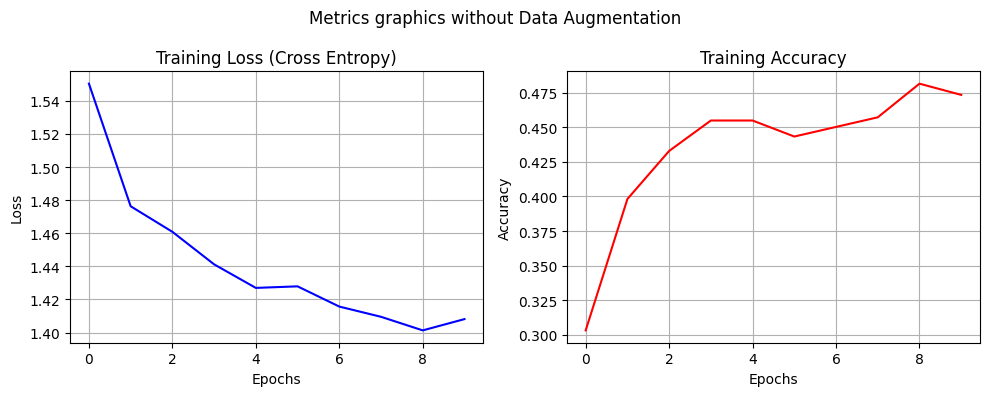

In [72]:
plot_loss_and_accuracy(history, model.num_epochs, fig_title='Metrics graphics without Data Augmentation')

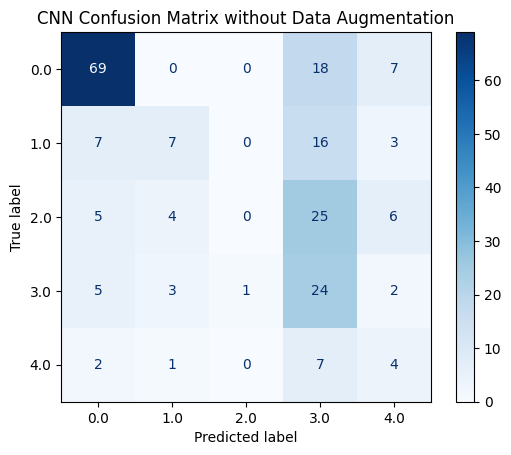

In [73]:
ConfusionMatrixDisplay(confusion_matrix(truth, preds), display_labels=np.unique(truth)).plot(cmap='Blues')
plt.title("CNN Confusion Matrix without Data Augmentation")
plt.show()

## Post-analysis

In [74]:
def plot_false_positives_class0(preds, truth, images, num_images_per_class=5, show_reference=True):
    preds = np.asarray(preds)
    truth = np.asarray(truth)

    fp_mask = (preds == 0) & (truth != 0)
    tp_mask = (preds == 0) & (truth == 0)
    if not np.any(fp_mask):
        print("Aucun faux positif pour la classe 0.")
        return

    class_labels = np.unique(truth[fp_mask])
    extra_row = 1 if show_reference and np.any(tp_mask) else 0
    n_rows = len(class_labels) + extra_row
    n_cols = num_images_per_class

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axs = np.atleast_2d(axs)

    current_row = 0
    if extra_row:
        ref_indices = np.where(tp_mask)[0][:num_images_per_class]
        for col in range(n_cols):
            ax = axs[current_row, col]
            if col < len(ref_indices):
                idx = ref_indices[col]
                ax.imshow(images[idx])
                ax.set_title("Vérité: 0 | Prédit: 0")
                ax.axis("off")
            else:
                ax.axis("off")
        axs[current_row, 0].set_ylabel("Classe 0 ref", rotation=90, fontsize=12)
        current_row += 1

    for cls in class_labels:
        cls_indices = np.where(fp_mask & (truth == cls))[0][:num_images_per_class]
        for col in range(n_cols):
            ax = axs[current_row, col]
            if col < len(cls_indices):
                idx = cls_indices[col]
                ax.imshow(images[idx])
                ax.set_title(f"Vérité: {int(truth[idx])} | Prédit: 0")
                ax.axis("off")
            else:
                ax.axis("off")
        axs[current_row, 0].set_ylabel(f"Classe {int(cls)}", rotation=90, fontsize=12)
        current_row += 1

    fig.suptitle(
        f"Faux positifs (prédit 0) avec référence", fontsize=16
    )
    plt.tight_layout()
    plt.show()

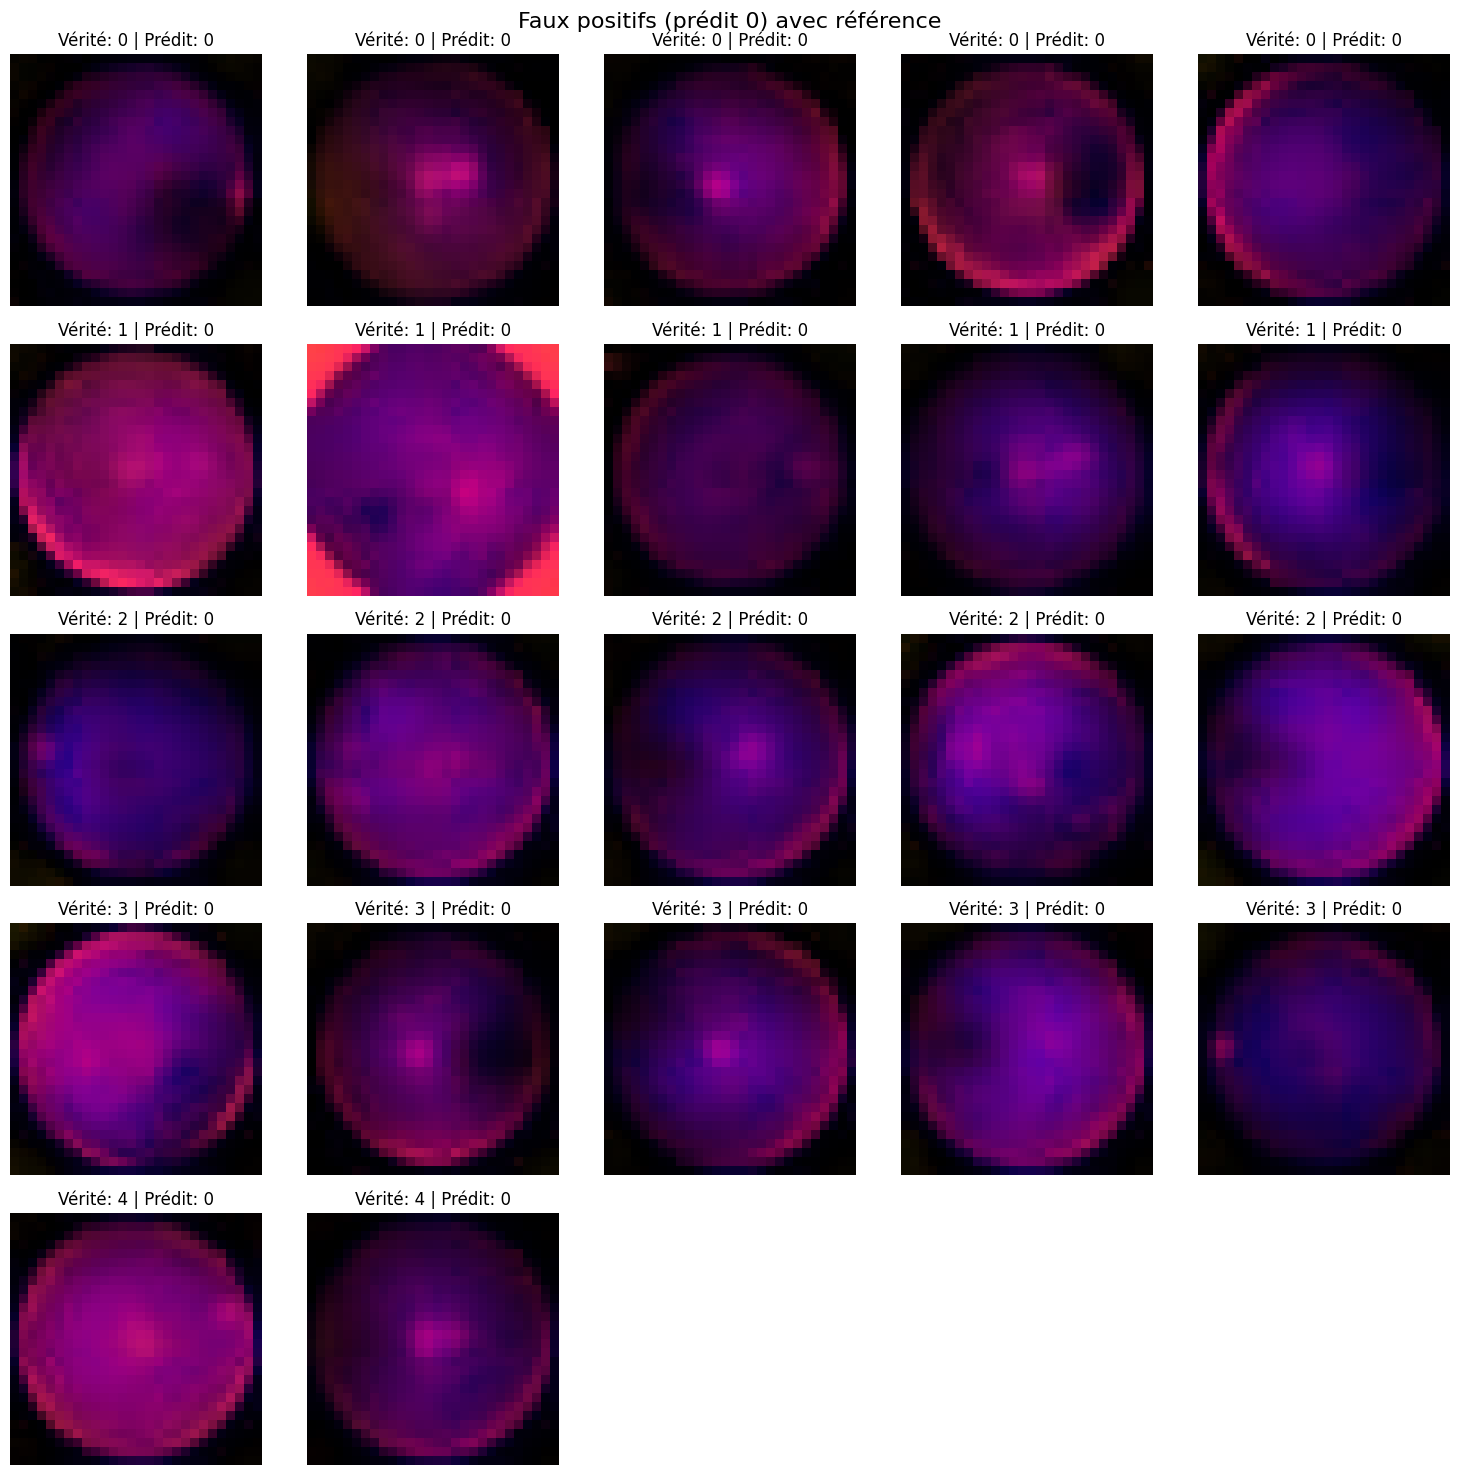

In [75]:
plot_false_positives_class0(preds, truth, images)

# Data Augmentation Version

In [76]:
# Charger le fichier Pickle
train_data_path = Path('data/train_data.pkl')
with open(train_data_path, 'rb') as f:
    data = pickle.load(f)

images = data['images']
labels = data['labels']

On refait la même chose, mais maintenant en enrichissant notre "dataset" original :

In [77]:
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)

In [78]:
train_transforms = transforms_v2.Compose([
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.RandomRotation(15),
    transforms_v2.RandomCrop(28, padding=4),
    transforms_v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms_v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms_v2.ToTensor(),
    transforms_v2.Normalize(MEAN, STD)
])

/opt/anaconda3/envs/kaggle_2/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [79]:
classes = np.unique(labels)
classes

array([0, 1, 2, 3, 4], dtype=uint8)

In [80]:
def unnormalize(tensor):
    img = tensor.numpy().transpose((1, 2, 0))
    img = STD * img + MEAN
    img = np.clip(img, 0, 1)
    return img

def show_augmented_vs_original(transform, dataset, num_images=8):
    # Transformer vers des images (PIL)
    pil_images = [Image.fromarray(array, mode='RGB') for array in dataset]

    # Appliquer les augmentations
    augmented_images = [transform(img) for img in pil_images]

    fig, axs = plt.subplots(2, num_images, figsize=(16, 4))
    fig.suptitle('Images originales (Top) vs. Images augmentées (Bottom)', fontsize=16)

    for i in range(num_images):
        axs[0, i].imshow(pil_images[i])
        axs[0, i].axis('off')
        if i == 0:
            axs[0, i].set_ylabel('Originales', fontsize=12)

        img = unnormalize(augmented_images[i])
        axs[1, i].imshow(img)
        axs[1, i].axis('off')
        if i == 0:
            axs[1, i].set_ylabel('Augmentées', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

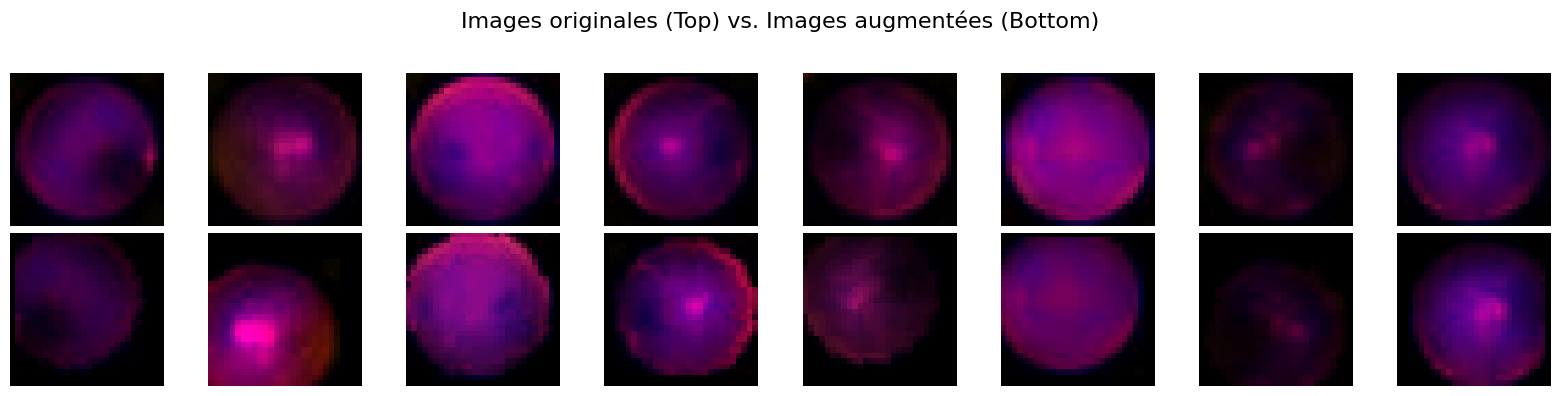

In [81]:
show_augmented_vs_original(transform=train_transforms, dataset=images)

In [82]:
AUGMENTATION_PRESETS = [
    transforms_v2.RandomRotation(degrees=8),
    transforms_v2.RandomCrop(28, padding=3),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.RandomAffine(degrees=0, shear=10, translate=(0.08, 0.08), scale=(0.95, 1.05)),
    transforms_v2.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.15),
    transforms_v2.RandomAutocontrast(p=0.5),
    transforms_v2.RandomAdjustSharpness(sharpness_factor=1.4, p=0.3),
    transforms_v2.RandomEqualize(p=0.3),
    transforms_v2.RandomErasing(p=0.25, scale=(0.01, 0.05), ratio=(0.3, 3.3))
]

In [83]:
def augment_dataset(images, labels, n_augmentations=5):
    print(f"Dataset original : {len(images)} images")
    
    augmented_images = []
    augmented_labels = []
    
    for idx, (img, label) in enumerate(zip(images, labels)):
        # Ajouter l'image originale
        augmented_images.append(img)
        augmented_labels.append(label)
        
        # Créer les versions augmentées
        pil_img = Image.fromarray(img, mode='RGB')
        
        for _ in range(n_augmentations - 1):
            # Nombre de transformations
            num_tr = len(AUGMENTATION_PRESETS) // 2
            # Génération selon la liste
            transforms = random.sample(AUGMENTATION_PRESETS, num_tr)
            tr_to_apply = transforms_v2.Compose(transforms)
            # Transformation
            aug_img = tr_to_apply(pil_img)
            aug_img_np = np.array(aug_img)
            
            augmented_images.append(aug_img_np)
            augmented_labels.append(label)
        
        if (idx + 1) % 100 == 0:
            print(f'Progression : {idx + 1}/{len(images)} images traitées')
    
    au_images = np.array(augmented_images)
    au_labels = np.array(augmented_labels)
    
    print(f'Dataset augmenté : {len(au_images)} images')
    print(f'Facteur de multiplication : x{len(au_images) / len(images):.1f}')
    
    return au_images, au_labels

## Training with Data Augmentation

In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(images, labels.flatten(), test_size=0.2, random_state=42)

In [85]:
X_train, y_train = augment_dataset(X_train, y_train, n_augmentations=10)

Dataset original : 864 images
Progression : 100/864 images traitées
Progression : 200/864 images traitées
Progression : 300/864 images traitées
Progression : 400/864 images traitées
Progression : 500/864 images traitées
Progression : 600/864 images traitées
Progression : 700/864 images traitées
Progression : 800/864 images traitées
Dataset augmenté : 8640 images
Facteur de multiplication : x10.0


In [86]:
X_train = torch.tensor(X_train, dtype=torch.float32) / 255.0
X_valid = torch.tensor(X_valid, dtype=torch.float32) / 255.0

X_train = X_train.permute(0, 3, 1, 2)
X_valid = X_valid.permute(0, 3, 1, 2)

y_train = torch.tensor(y_train, dtype=torch.long)
y_valid = torch.tensor(y_valid, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

train_dataset.train = True
valid_dataset.train = False

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

In [87]:
model.num_epochs = 12
model.criterion = nn.CrossEntropyLoss()
model.optimizer = optim.SGD(model.parameters(), lr=0.001)

In [88]:
history = model.train_model(train_loader)

 ===== Epoch [1/12] done ===== 
 ===== Epoch [2/12] done ===== 
 ===== Epoch [3/12] done ===== 
 ===== Epoch [4/12] done ===== 
 ===== Epoch [5/12] done ===== 
 ===== Epoch [6/12] done ===== 
 ===== Epoch [7/12] done ===== 
 ===== Epoch [8/12] done ===== 
 ===== Epoch [9/12] done ===== 
 ===== Epoch [10/12] done ===== 
 ===== Epoch [11/12] done ===== 
 ===== Epoch [12/12] done ===== 


In [89]:
_, _ = check_accuracy(train_loader, model)

Checking accuracy on training data
Got 4186/8640 with accuracy 48.45%


In [90]:
preds, truth = check_accuracy(val_loader, model)

Checking accuracy on validation data
Got 106/216 with accuracy 49.07%


## Metrics

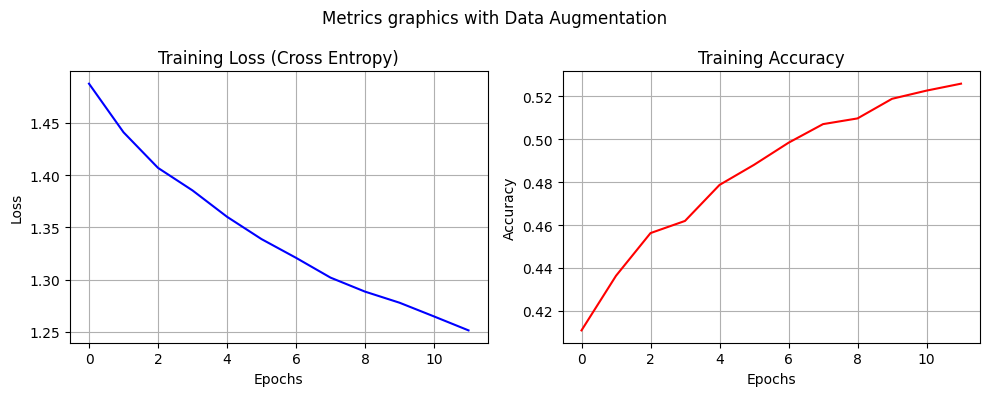

In [91]:
plot_loss_and_accuracy(history, model.num_epochs, fig_title='Metrics graphics with Data Augmentation')

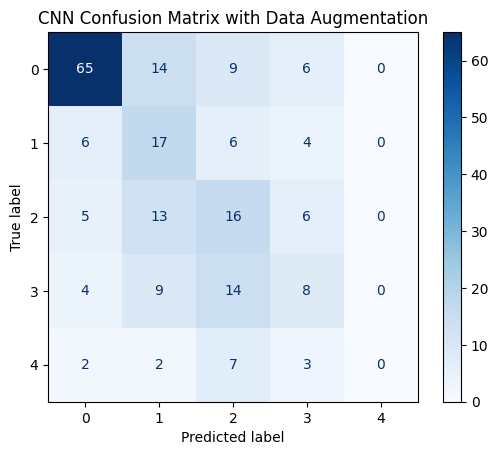

In [92]:
ConfusionMatrixDisplay(confusion_matrix(truth, preds), display_labels=np.unique(truth)).plot(cmap='Blues')
plt.title("CNN Confusion Matrix with Data Augmentation")
plt.show()

# Test Set

In [93]:
# Charger les fichiers Pickle
with open(train_data_path, 'rb') as f:
    train_data = pickle.load(f)

test_data_path = Path('data/test_data.pkl')
with open(test_data_path, 'rb') as f:
    test_data = pickle.load(f)

train_images = train_data['images']
train_labels = train_data['labels']

test_images = test_data['images']

In [94]:
test_images.shape

(400, 28, 28, 3)

Ré-entraîner le modèle avec l'ensemble d'entraînement + l'ensemble de valdidation :

In [95]:
X_train, y_train = augment_dataset(train_images, train_labels.flatten(), n_augmentations=10)

Dataset original : 1080 images
Progression : 100/1080 images traitées
Progression : 200/1080 images traitées
Progression : 300/1080 images traitées
Progression : 400/1080 images traitées
Progression : 500/1080 images traitées
Progression : 600/1080 images traitées
Progression : 700/1080 images traitées
Progression : 800/1080 images traitées
Progression : 900/1080 images traitées
Progression : 1000/1080 images traitées
Dataset augmenté : 10800 images
Facteur de multiplication : x10.0


In [96]:
X_train = torch.tensor(X_train, dtype=torch.float32) / 255.0
X_test = torch.tensor(test_images, dtype=torch.float32) / 255.0

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

y_train = torch.tensor(y_train, dtype=torch.float32)

In [97]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [98]:
_ = model.train_model(train_loader)

 ===== Epoch [1/12] done ===== 
 ===== Epoch [2/12] done ===== 
 ===== Epoch [3/12] done ===== 
 ===== Epoch [4/12] done ===== 
 ===== Epoch [5/12] done ===== 
 ===== Epoch [6/12] done ===== 
 ===== Epoch [7/12] done ===== 
 ===== Epoch [8/12] done ===== 
 ===== Epoch [9/12] done ===== 
 ===== Epoch [10/12] done ===== 
 ===== Epoch [11/12] done ===== 
 ===== Epoch [12/12] done ===== 


In [99]:
preds = model.get_predictions(test_loader)
preds.shape

torch.Size([400])

In [100]:
preds = preds.cpu()
preds

tensor([0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 3, 0, 3, 3, 0, 3, 3, 3, 3, 0, 0, 0, 0,
        0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 3, 3, 3, 0, 3,
        3, 0, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 0, 3, 0, 0, 1, 0, 3, 1, 3, 0, 0,
        0, 0, 3, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3, 3, 0, 1, 3, 0, 3, 1, 3,
        3, 3, 0, 0, 0, 3, 0, 3, 2, 1, 0, 0, 0, 0, 3, 1, 0, 1, 0, 3, 3, 2, 3, 0,
        3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 0, 3, 2, 0, 3, 2, 0, 0, 1, 0,
        1, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 3, 1, 0, 3, 0, 3, 0, 0, 3, 3, 3, 3, 2,
        3, 3, 2, 0, 2, 1, 1, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3,
        3, 0, 0, 3, 2, 3, 3, 3, 3, 0, 1, 0, 3, 3, 2, 2, 3, 3, 0, 3, 3, 0, 0, 3,
        0, 3, 3, 3, 0, 1, 3, 2, 2, 3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3,
        3, 1, 0, 0, 0, 3, 0, 3, 1, 3, 1, 0, 3, 1, 3, 0, 3, 0, 0, 3, 3, 3, 3, 1,
        1, 3, 0, 0, 0, 0, 3, 3, 3, 3, 0, 3, 2, 3, 3, 3, 2, 3, 3, 2, 0, 3, 1, 3,
        3, 3, 2, 3, 3, 1, 0, 3, 3, 3, 0,

In [101]:
model_name = 'CNN'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"submission_{model_name}_{timestamp}.csv"

In [102]:
path = 'output/'
if not os.path.isdir(path): os.mkdir(path)
fn_path = Path(os.path.join(path, filename))

In [103]:
data = {
    'ID': np.arange(1, len(preds) + 1),
    'Label': preds
}

output_df = pd.DataFrame(data)
output_df

,ID,Label
0,1,0
1,2,1
2,3,3
3,4,3
4,5,0
...,...,...
395,396,0
396,397,3
397,398,3
398,399,0


In [104]:
output_df.to_csv(fn_path, index=False)